<div>
    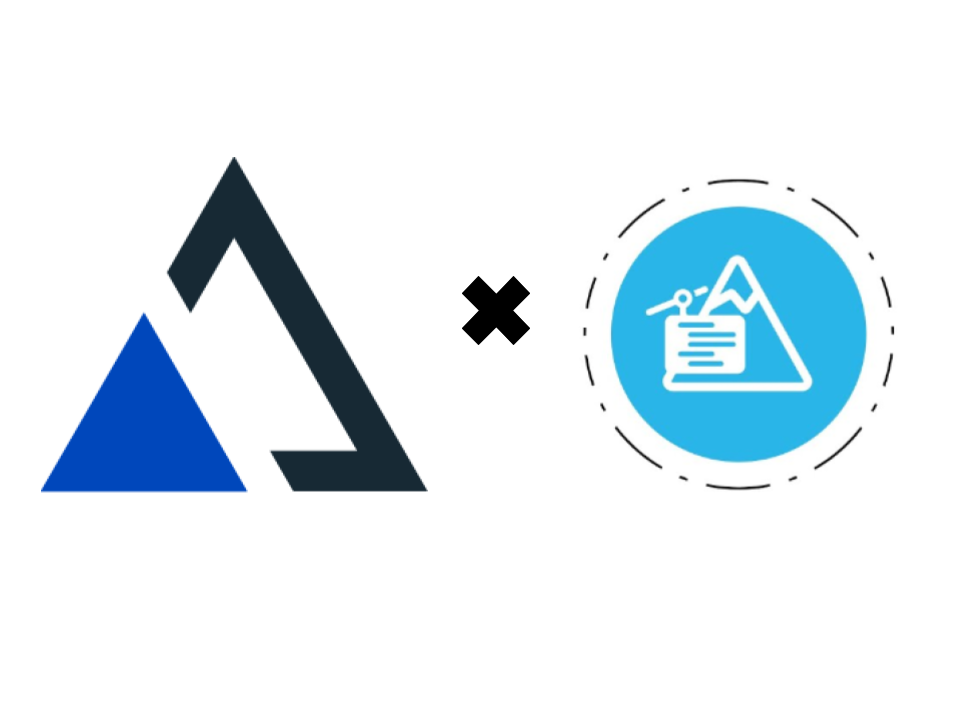
</div>

<h1 style = "text-align: center;"><font size = 8px color = "#0047BB">Advanced AI-Link x Snowpark </font></h1>

<p style="margin-left: 25px;">
For the purposes of this demo we are going to be using the <b>Walmart M5 Dataset</b> <a href = "https://www.kaggle.com/competitions/m5-forecasting-accuracy"> from Kaggle</a>. This dataset contains historical sales information </p>across several locations in three states. As they are the <b>largest domestic retail store</b>, it's safe to assume Walmart has a lot of sales data. The M5 dataset represents only a fraction of their stores and it is 60 million rows of data. There are 4,630 stores in the country, so as one would expect we are presented with a problem. Data movement would be pricey and time consuming, so <b>how can we avoid this problem?</b> <font color = "#62c4f5"><b>Snowpark</b></font> lets us edit our data where it is; we take the code to the data instead of the data to the code. 


<p style="margin-left: 25px;">
Our business team has decided they would like forecasted information on <b>units sold for any given item on any given day in any given store</b>. How </p>can we offer insights on such a granular level while still hitting our data engineering team policy of <b>at least 85% accuracy</b> on forcasting? We can use <font color = "#1b1899"><b>AI Link</b></font>, to pull some of our transformed data to a local environment where we can expirement, then from there we can proceed to <font color = "#62c4f5"><b>Snowpark</b></font> and <b>expand our local model to a global model</b> that we use across all of our stores. With AI-Link's capabilities we can ensure our ML models operate off of the same data transformations our business team does. 
</br></br></br>
<font color = "0077A7">In this demo we go a bit further than our <a href = "https://github.com/AtScaleInc/python-api/tree/main/notebooks"> Intermediate Integration Demo</a> in the following ways:
<ol><li>We'll do all data engineering with AI-Link</li>
    <li>We'll connect our Snowpark Prediction UDF to our Semantic Model as a QDS</li> 
    <li>And test our model on the full dataset after training it</li></ol></font>

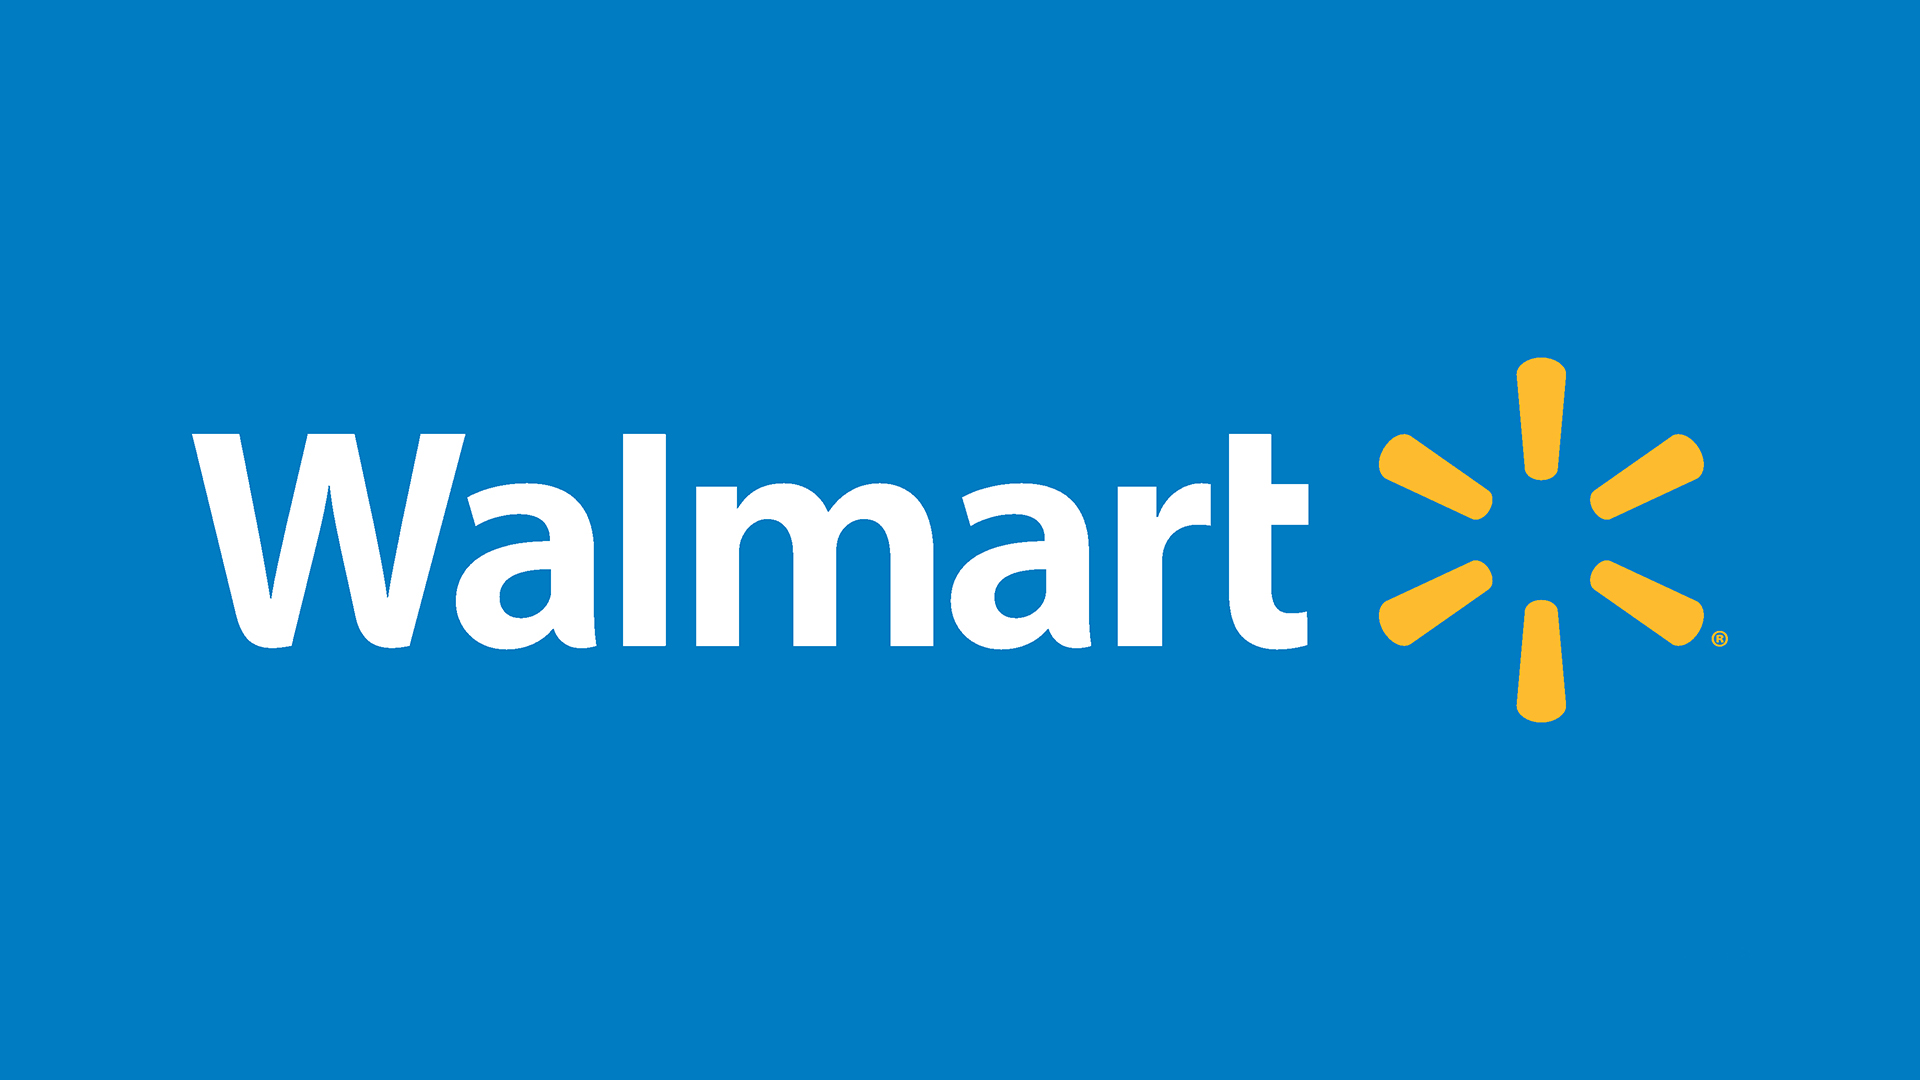

<h6>Prerequistes & Assumptions:</h6>
<ol><li><b>AtScale Python API</b> installed as detailed <a href = "https://github.com/AtScaleInc/python-api"> on our GitHub </a></li>
    <li><b>Snowpark</b> installed as detailed <a href = "https://docs.snowflake.com/en/developer-guide/snowpark/python/setup"> here </a></li>
    <li>You have your environment configured with <a href = "https://drive.google.com/file/d/1vs-CEc3K42n1WDGBmfqwZxyT0tLTi89d/view?usp=drive_link"> these dependencies for Snowpark </a></li>
    <li>You have configured your <b>AtScale and Snowflake permissions</b> into a local JSON</li>
    <li>You are using Python <b>3.8</b></li>
    <li>You have already created a <b>semantic model</b> in AtScale</li>
    <li>You are <b>quite familiar</b> with AI-Link, AtScale, and Snowpark. Where our first two demos focused on the <b>what</b>, this demo will focus on the Advanced applications and <b>why</b> AI-Link and Snowpark work well together</li>
    </ol>

In [ ]:
# AtScale Imports
from atscale.client import Client
from atscale.data_model import DataModel
from atscale.project import Project
from atscale.eda.feature_engineering import *
from atscale.utils import prediction_utils

# Snowpark imports
from snowflake.snowpark.functions import (
    array_construct,
    call_udf,
    col,
    lit,
    month,
    sum,
    udf,
    year,
)
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import (
    DateType,
    FloatType,
    IntegerType,
    StringType,
    StructField,
    StructType,
    Variant,
)
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.types as T


# Third Party Packages
import pandas as pd
import numpy as np
import os
import sys
import pkg_resources
import json
import joblib

<h3>Read our permissions and packages JSONs</h3>

For more information on the content or structure of both of these files, please see the AI-Link X Snowpark Minimal Demo.

In [ ]:
with open("/permissions") as file:
    permissions = json.load(file)
    
with open("/requirements") as f:
    packages_version = json.load(f)

<h3>AI-Link & Snowpark initialization</h3>

These connections should be familiar to you by now, one thing we recommend is creating a snapshot of your project so you have a backup in case you would like to revert

In [ ]:
client = Client(
    server=permissions["atscale_server"],
    organization=permissions["atscale_organization"],
    username=permissions["atscale_username"],
    password=permissions["atscale_password"],
)

In [ ]:
client.connect()

In [ ]:
project = client.select_project(name_contains = permissions["atscale_project"])
data_model = project.select_data_model(name_contains = permissions["atscale_data_model"])

In [ ]:
connection_parameters = {
    "account": permissions["snowflake_account"],
    "user": permissions["snowflake_username"],
    "password": permissions["snowflake_password"],
    "role": permissions["snowflake_role"],
    "warehouse": permissions["snowflake_warehouse"],
    "database": permissions["snowflake_database"],
    "schema": permissions["snowflake_schema"],
}

In [ ]:
session = Session.builder.configs(connection_parameters).create()

In [ ]:
session.sql("CREATE STAGE IF NOT EXISTS ADVANCED_STAGE").collect()

<h3>Feature Engineering Done Right</h3>

If you've explored our Intermediate Demo you'll know we did feature engineering locally in Python with pandas dataframes. This is advantageous to the new user. Python and pandas feature engineering is easy and well documented. That being said, local changes are not useful in deployment. 

In order to show off AI-Link's full capabilites, and more importantly how we think you should use AI-Link and Snowpark in deployment, we are going to create calculated features for model training and forecasting. Below we are going to <font style = "text-decoration: underline">create two new calculated features</font> using <code>create_calculated_feature()</code> which takes a feature name and an mdx statement defining the feature. 

<b>Unit Price</b> is calculated by dividing the total_sales by the total_units_sold. Note the <code>CASE</code> statement to catch when our total units sold is 0 so we avoid dividing by 0. 

<b>Sales Outlier</b> will be our <font style = "text-decoration: underline">target column for modeling</font>. We set this column equal to <i>1 when the total_units_sold are five above the average_prev_week_units_sold</i>, if this is not the case then we set the column to 0. Using a <code>CASE</code> statement here allows us to also catch null values as a 0. 

In [ ]:
data_model.delete_measures(["unit_price","sales_outlier"])

In [ ]:
names = ["unit_price", "sales_outlier"]

mdx = ["CASE WHEN [Measures].[total_units_sold] = 0 THEN 0 ELSE [Measures].[total_sales]/[Measures].[total_units_sold] END",
      "CASE WHEN [Measures].[total_units_sold] > [Measures].[avg_prev_week_units_sold] + 5 THEN 1 ELSE 0 END"]

for i in range(len(names)):
    data_model.create_calculated_feature(names[i], mdx[i])

<h3>AI-Link's Snowpark Super Power</h3>

The ability to use AI-Link's <code>get_database_query()</code> in conjuction with Snowpark is MASSIVELY useful in three big ways:<br><b>Speed:</b> Handling an SQL query rather than the data itself allows us to move around far faster. We can generate our query, write it to Snowflake, read it, and run it all in a matter of seconds. <br><b>Compute:</b> Using our query we never have to move data out of Snowflake's domain. We can create our dataframe in a Snowpark SPROC on Snowflake's compute, and we won't have to move an ounce of data through AtScale or our local environment. <br><b>Consistency:</b> Using a query we follow AtScale's main theme, making all our teams and queries speak the same language. In using it, we are unifying multiple fact tables into a single dataframe. From that dataframe we will be able to join our models back into our Semantic Model, making our ML Team speak the same language as our Business Team. 

In [ ]:
%%time
query = data_model.get_database_query(feature_list = ['date', 'store', 'item', 
                          'total_sales','total_units_sold', 
                          'previous_days_units_sold',
                          'avg_prev_week_units_sold', 'day_of_week', 
                          'total_units_sold_28_days',
                          'total_units_sold_30_prd_mv_avg',
                          'unit_price', 'sales_outlier'
                         ])

<h3>Staging our Query</h3>

To make our elaborate (48,764 Characters!) SQL query accessible to our Snowpark SPROCs we are going to <font style = "text-decoration: underline">put the SQL query file on our Advanced Stage</font> by using joblib to compress it and Snowpark's <code>session.file.put()</code> to move it to Snowflake. To get around Snowflake's lack of external network access, we are going to make our query internal by writing it first. Of course this does not reflect live changes to your AtScale instance, but it is a remedy. 

In [ ]:
file = os.path.join("/tmp", "query_file")
joblib.dump(query, file)

session.file.put(file,"@ADVANCED_STAGE", auto_compress=False, overwrite=True)

<h3>SPROC for Training and Saving</h3>

We are now going to create a stored procedure for training and saving our model. This model will be the XGBoost regressor which is very accurate, but also a little computationally slow. More importantly XGBoost's regressor handles null values in predictions meaning we don't have to worry about any null values throwing errors. We also want to add an import for our query file and train our model using our query to create our dataframe. Notice how by using our query and doing our feature engineering on the AtScale project <font style = "text-decoration: underline">we have managed to eliminate the need to move data locally at all</font>. We can train and save a model all in the cloud.  

In [ ]:
session.add_import('@"AI_LINK"."SNOWPARK_TESTING"."ADVANCED_STAGE"/query_file')

def train_and_save(session: Session) -> str:
    import sys
    from xgboost import XGBRegressor
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedKFold
    
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    q_file = import_dir + "query_file"
    query = joblib.load(q_file)
    
    df = session.sql(query).to_pandas()

    feature_columns = ["total_sales", "previous_days_units_sold", "avg_prev_week_units_sold",
                   "day_of_week", "total_units_sold_28_days", "total_units_sold_30_prd_mv_avg", "unit_price"]

    model = XGBRegressor()
    X = np.array(df[feature_columns])
    y = np.array(df["sales_outlier"])
    model.fit(X,y)
    
    model_file = os.path.join("/tmp", "LogReg_Model")
    joblib.dump(model, model_file)
    session.file.put(model_file, "@advanced_stage", auto_compress=False, overwrite=True)
    
    return("Success")

In [ ]:
%%time
train_and_save = session.sproc.register(func=train_and_save, name='train_and_save', is_permanent=True, 
                                  replace=True, stage_location='@advanced_stage',
                                  packages=[f'snowflake-snowpark-python=={packages_version["snowflake-snowpark-python"]}'
                                            ,f'scikit-learn=={packages_version["scikit-learn"]}'
                                            ,f'joblib=={packages_version["joblib"]}'
                                            ,f'xgboost==1.7.3'])


Then let's run our stored procedure so we have our model file on our Advanced Stage

In [ ]:
%%time
print(train_and_save(session))

<h3>Forecasting UDF</h3>

Now we are going to create a forecasting UDF that will go through line by line and <font style = "text-decoration: underline">predict for any given row if that row will be a sales outlier</font>. 

In [ ]:
session.clear_imports()
session.clear_packages()
session.add_import("@ADVANCED_STAGE/LogReg_Model")

@udf(name = "forecast", session = session, replace = True, packages = ["pandas", "joblib", "scikit-learn", "xgboost"], stage_location = "Advanced_Stage")
def forecast(inps: list) -> int:
    import sys
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_file = import_dir + "LogReg_Model"
    model = joblib.load(model_file)
    
    table_columns = ["total_sales", "previous_days_units_sold", "avg_prev_week_units_sold",
                   "day_of_week", "total_units_sold_28_days", "total_units_sold_30_prd_mv_avg", "unit_price"]
    

    df = pd.DataFrame([inps[0:7]], columns = table_columns)
    X = np.array(df)
    prediction = model.predict(X)
    prediction = prediction.round()
    return prediction

<h3>Local Call to Check the Accuracy</h3>

In [ ]:
%%time
test_accuracy_table = session.sql(query)
out = test_accuracy_table.select('"total_sales"','"previous_days_units_sold"', '"avg_prev_week_units_sold"', '"day_of_week"',
             '"total_units_sold_28_days"','"total_units_sold_30_prd_mv_avg"','"unit_price"', '"sales_outlier"',
             call_udf("forecast", 
                 array_construct(
                     col('"total_sales"'), col('"previous_days_units_sold"'), col('"avg_prev_week_units_sold"'), 
                     col('"day_of_week"'), col('"total_units_sold_28_days"'), col('"total_units_sold_30_prd_mv_avg"'), 
                     col('"unit_price"'))).as_("Forecasted"))
p = out.to_pandas()
p.head()

In [ ]:
correct = 0
incorrect = 0
TP, FP, TN, FN = 0, 0, 0, 0

for index, row in p.iterrows():
    actual = row["sales_outlier"]
    if actual == row["FORECASTED"]:
        correct += 1
        if actual == 1:
            TP += 1
        else:
            TN += 1
    else:
        incorrect+=1
        if actual == 1:
            FP += 1
        else:
            FN += 1
            
total = correct + incorrect
print("Success rate:", round((correct/(total))*100, 4))
print("True positive rate:", round((TP/total)*100, 4))
print("True negative rate:", round((TN/total)*100, 4))
print("False positive rate:", round((FP/total)*100, 4))
print("False negative rate:", round((FN/total)*100, 4))

***If you have already created a QDS for your UDF use this cell to wipe the created QDS and Measure.***

In [ ]:
project.delete_dataset("forecast")

<h1>Current Semantic Model</h1>

If we take a look at our current semantic model we can see our dimensions, datasets and measure. The BI user can interact with all theses features and pieces of our model. <b>However, the BI user is not yet able to view our UDF's forecasted output in any way</b>.

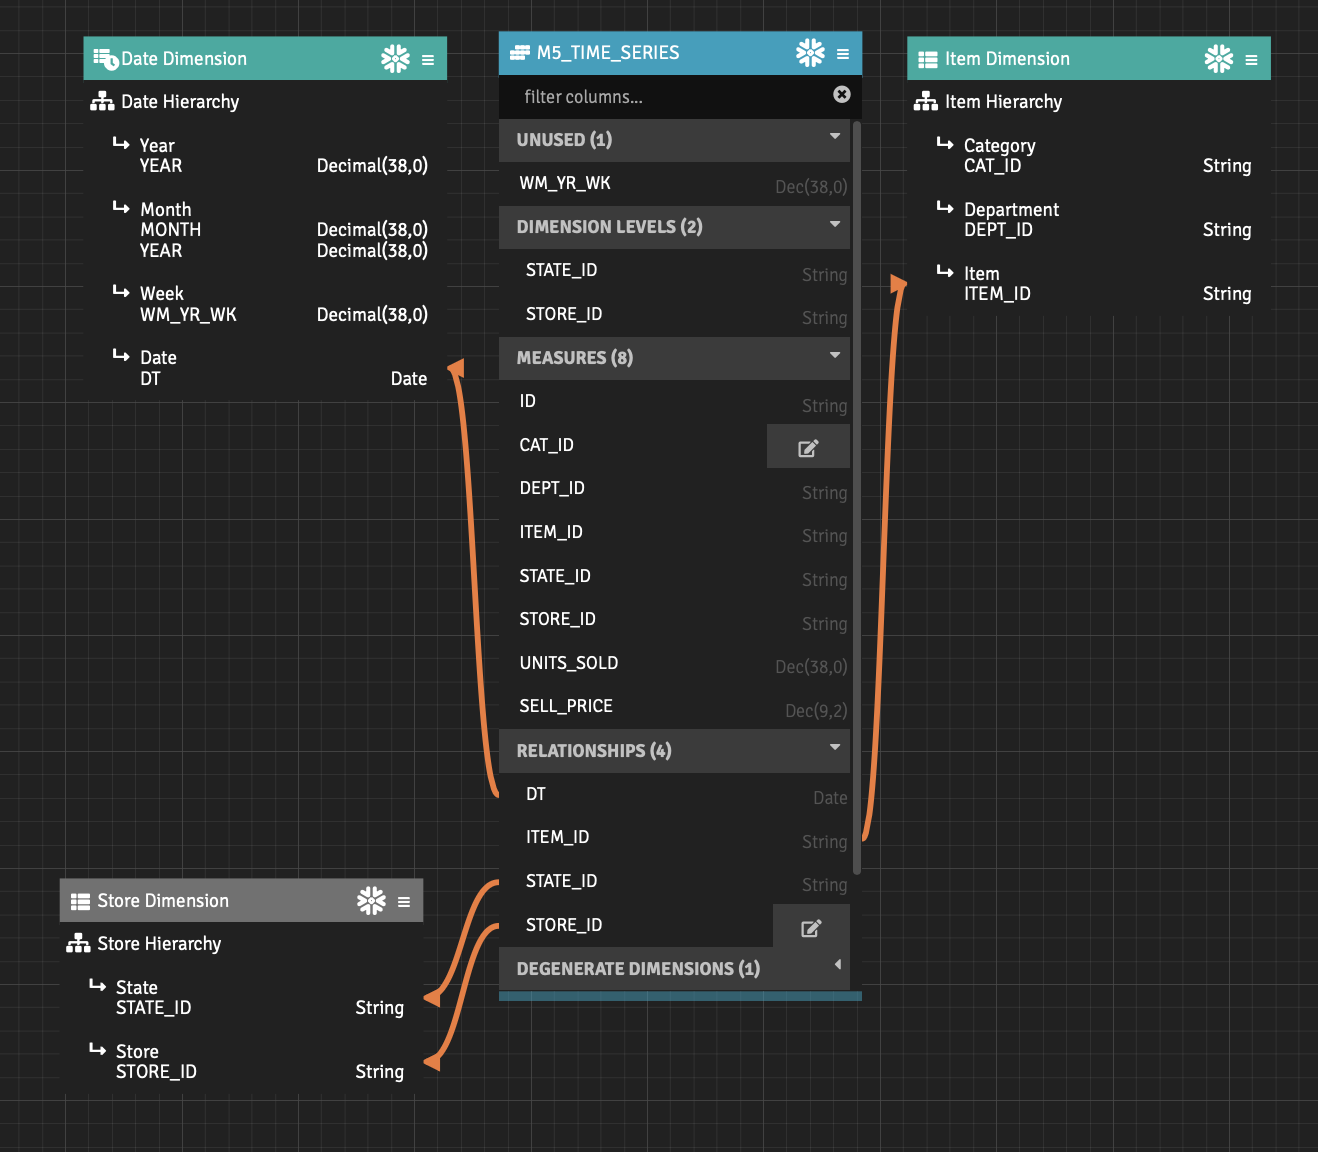

<h3>Join UDF for Semantic Inference</h3>

Using AI-Link's <code>join_df()</code> we can <font style = "text-decoration: underline">join our Snowpark UDF back into our pre-existing semantic model in the form of a QDS</font>. This QDS will allow our BI user to query the UDF without ever having to touch a line of code. 

This function has a few important inputs. We are going to define sp_udf here as the path to our UDF, this format is <i>warhouse.schema.udf</i>. Then we need to construct a list of all the inputs our UDF needs. Notice how date, item, and store are not actual inputs for our UDF; however, we need to pass them to ensure the UDF forecasts on the same level of granularity which it was trained on. We trained on the level of date, item, and store, so we will make sure this UDF recieves data on the same level. We are also going to use date, item, and store as our join features so we can later join our QDS back into our model so it can be accessed in the same query as our other measures and dimensions. Lastly we give the new generated column and the QDS a name. 

The next four lines of code structure the UDF call itself. You might notice this call is very reminiscent of the local call located above. Finally we make a UDF Database Query which is going to track where we get the data from in our data warehouse.

Finally, we can use AI-Link's <code>join_udf</code> to create our new QDS in our semantic model. You can check out the results in the semantic model as pictured below.

In [ ]:
sp_udf = '"AI_LINK"."SNOWPARK_TESTING"."FORECAST"'
udf_inputs = ['total_sales','previous_days_units_sold', 'avg_prev_week_units_sold', 'day_of_week',
             'total_units_sold_28_days','total_units_sold_30_prd_mv_avg','unit_price', 'date', 'item', 'store']
join_features = ['date', 'item', 'store']
new_feature_name = "predicted_value"
qds_name = "forecast"

feature_inputs = ", ".join(f'"{f}"' for f in udf_inputs)

snowpark_udf_call = f'{sp_udf}(array_construct({feature_inputs}))'

udf_database_query = data_model.get_database_query(feature_list = udf_inputs, use_aggs = False)

snowpark_udf_from_clause = f'({udf_database_query})'

In [ ]:
prediction_utils.join_udf(data_model=data_model,
                          target_columns=[f'{snowpark_udf_call} as "{new_feature_name}"'],
                          udf_call=snowpark_udf_from_clause,
                          join_features=join_features,
                          qds_name=qds_name)

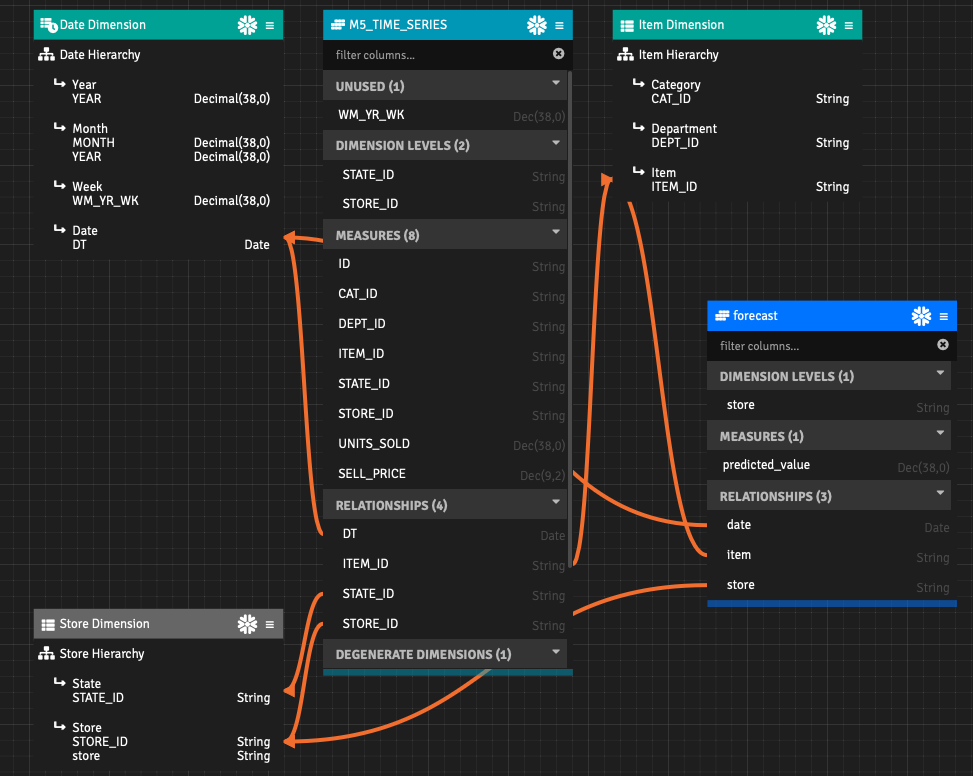<p style = "text-align: center">The QDS is represented by the bright blue object titled "<b>forecast"

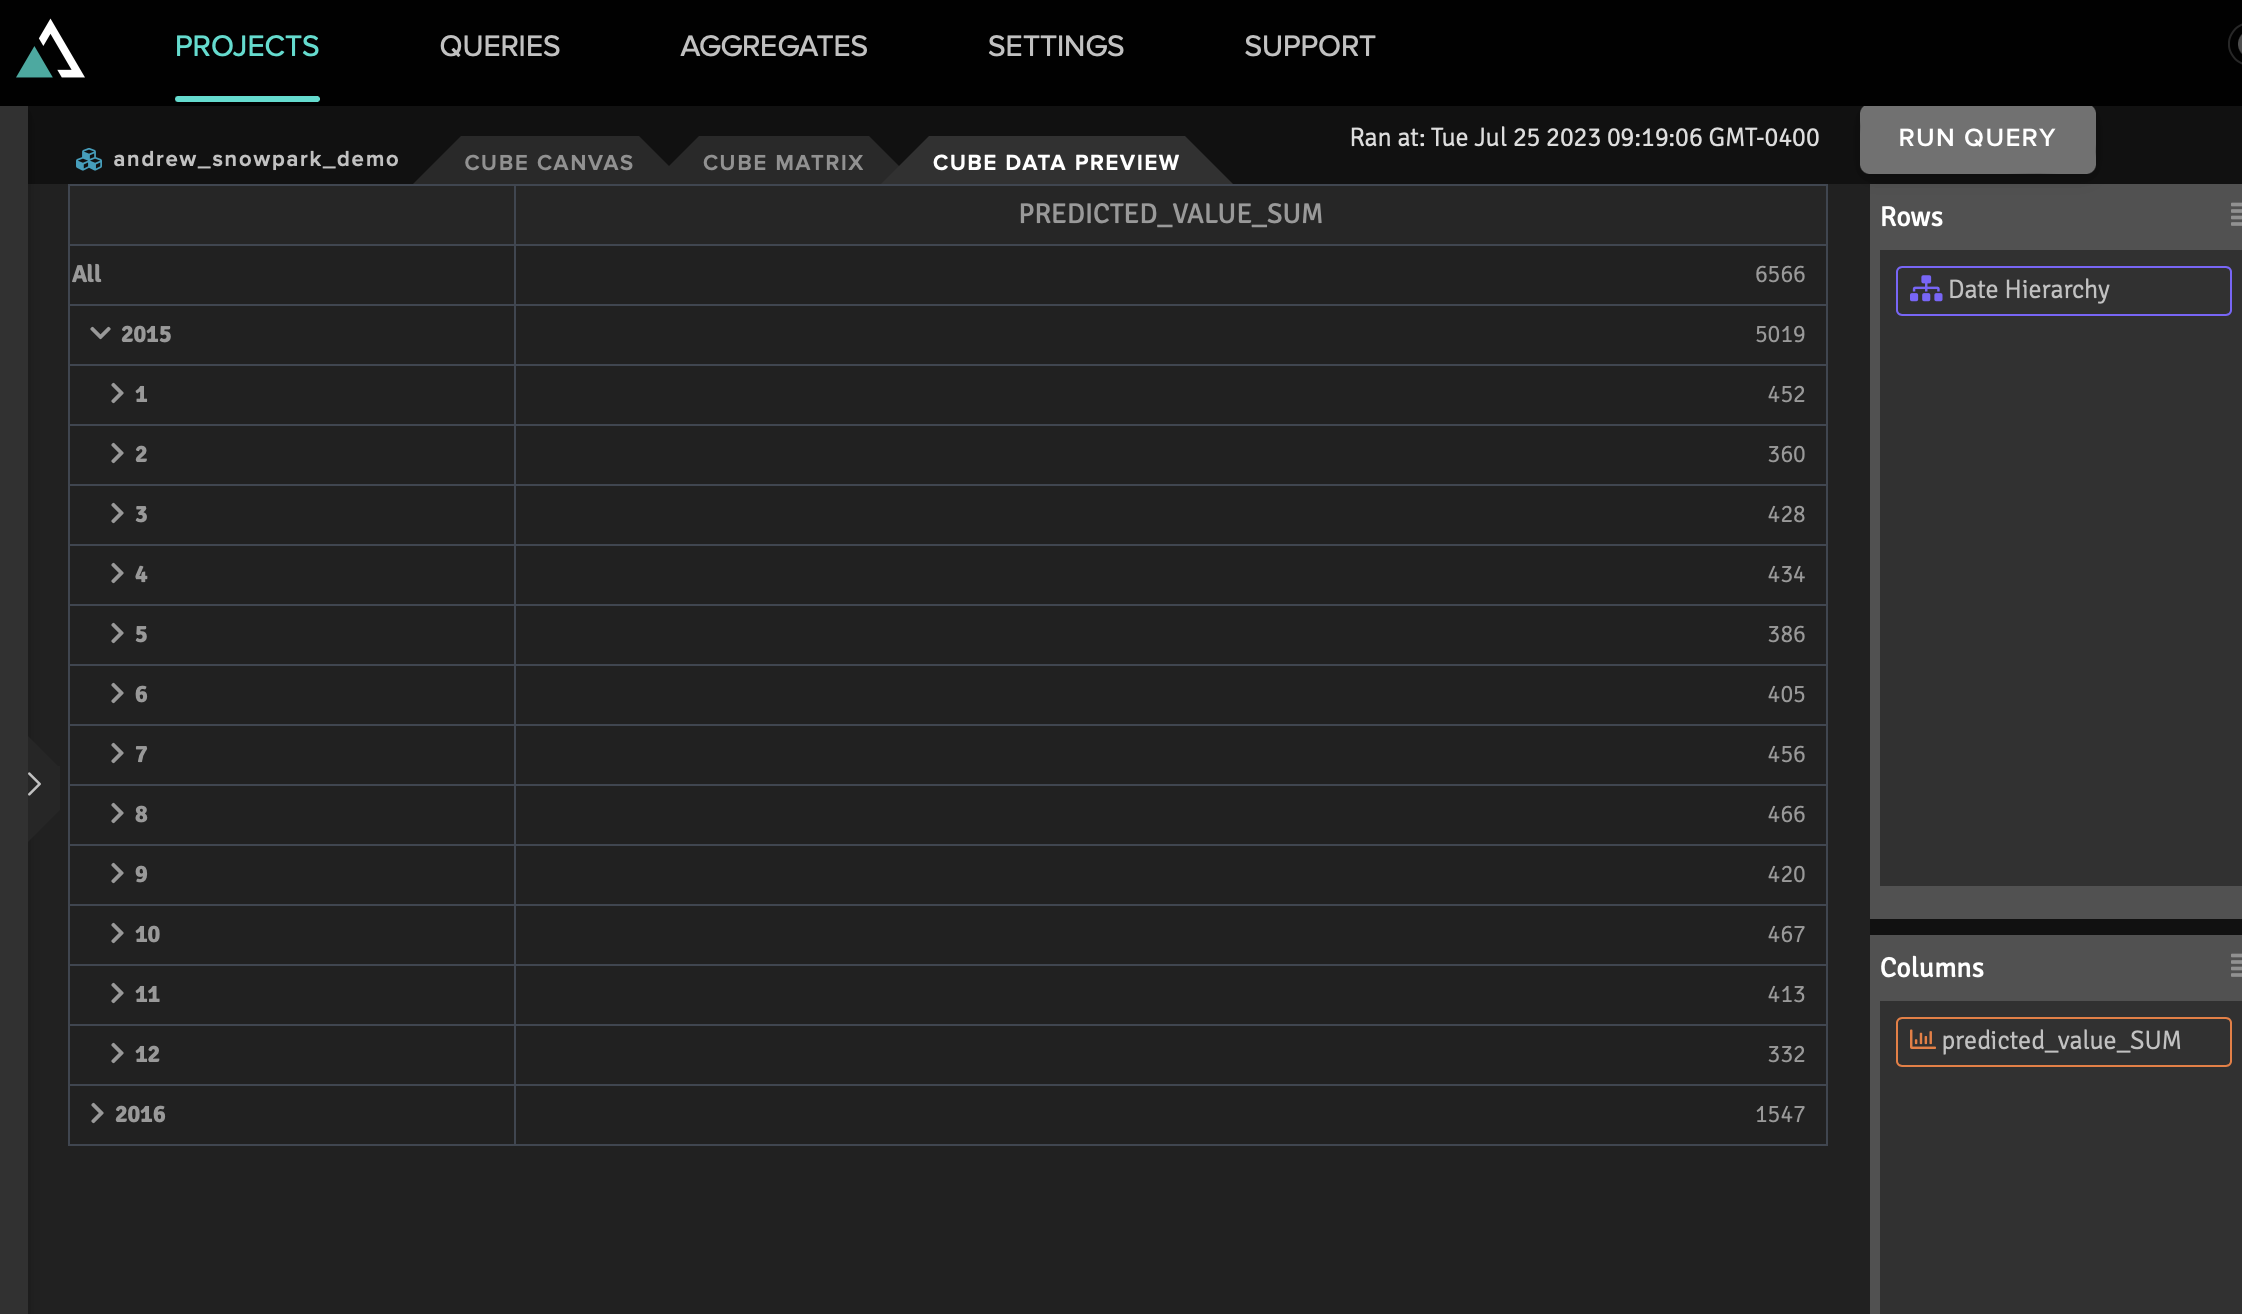
<p style = "text-align: center">In this view, we can see the number of items times in a given time frame that Walmart sold 5 or more over the average.

<h1>Now let's load up a BI tool and check it out</h1>

Using Tableau and the TDS which can be downloaded from <i>published project>datamodel>connect</i>, we can connect our semantic model to a BI tool and let our BI team query our UDF without every having to exit Tableau. By simply dragging and dropping measure/dimensions names we can see how many forecasted sales outlier item days we will have in each week. 

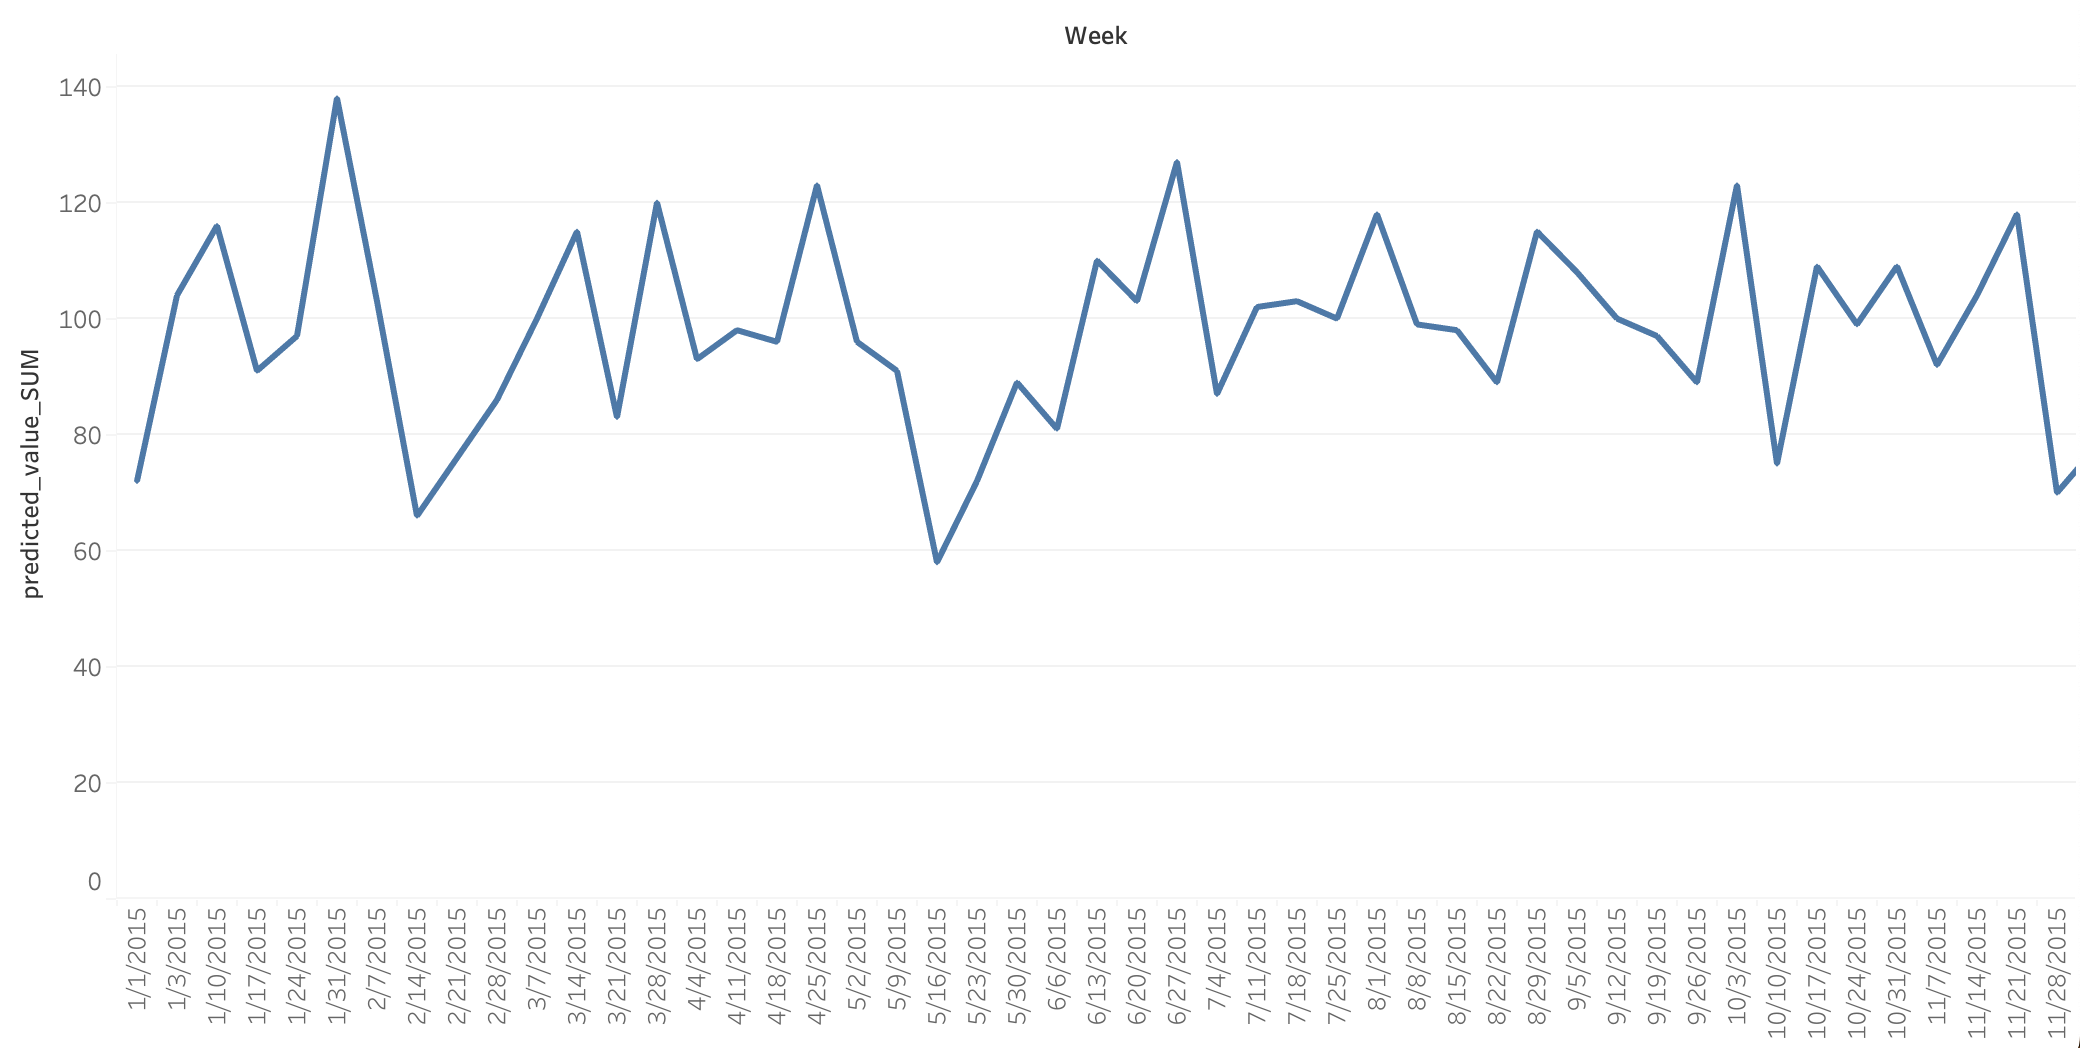

<h1> Using our model at scale

<font style = "text-decoration: underline">Another nice feature of putting a ML model in a UDF is it can be used on a much larger scale than it was trained on</font>. To show this off, we are going to navigate to a copy of the cube we just made called full_m5_data. Once we are in this cube in the AtScale canvas we can remap our data source to a much larger dataset of the same structure. In this case, we were <b>training our model and creating our UDF on the Walmart M5 Thin dataset (68,000 rows)</b>, but using remap data we can <b>predict on the full dataset (58,000,000 rows)</b>. Then we can generate a new query for the same features, and call the UDF on a larger slice of data to check its accuracy on new data. In the example below we are going to predict, and then check our accuracy on 100,000 rows of the full dataset.

In [ ]:
project2 = client.select_project(name_contains = permissions["atscale_project"])
data_model2 = project.select_data_model(name_contains = "full_m5_data")

In [ ]:
query2 = data_model2.get_database_query(feature_list = ['date', 'store', 'item', 
                          'total_sales','total_units_sold', 
                          'previous_days_units_sold',
                          'avg_prev_week_units_sold', 'day_of_week', 
                          'total_units_sold_28_days',
                          'total_units_sold_30_prd_mv_avg',
                          'unit_price', 'sales_outlier'
                         ])

In [ ]:
%%time
size = 250000
limited = query2 + " limit " + str(size)
table = session.sql(limited)

In [ ]:
%%time
out = table.select('"total_sales"','"previous_days_units_sold"', '"avg_prev_week_units_sold"', '"day_of_week"',
             '"total_units_sold_28_days"','"total_units_sold_30_prd_mv_avg"','"unit_price"', '"sales_outlier"',
             call_udf("forecast", 
                 array_construct(
                     col('"total_sales"'), col('"previous_days_units_sold"'), col('"avg_prev_week_units_sold"'), 
                     col('"day_of_week"'), col('"total_units_sold_28_days"'), col('"total_units_sold_30_prd_mv_avg"'), 
                     col('"unit_price"'))).as_("Forecasted"))
p = out.to_pandas()
print(p.shape)

In [ ]:
correct = 0
incorrect = 0
TP, FP, TN, FN = 0, 0, 0, 0

for index, row in p.iterrows():
    actual = row["sales_outlier"]
    if actual == row["FORECASTED"]:
        correct += 1
        if actual == 1:
            TP += 1
        else:
            TN += 1
    else:
        incorrect+=1
        if actual == 1:
            FP += 1
        else:
            FN += 1
            
total = correct + incorrect
print("Success rate:", round((correct/(total))*100, 4))
print("True positive rate:", round((TP/total)*100, 4))
print("True negative rate:", round((TN/total)*100, 4))
print("False positive rate:", round((FP/total)*100, 4))
print("False negative rate:", round((FN/total)*100, 4))

We can see that even when we use data the model has never seen our accuracy rate is high, and using AI-Link we still don't have to move the data to cast new predictions. 

In [ ]:
session.close()

### Summary

Using Snowpark and AI-Link we were able to:
<ol><li><b>Manipulate the raw data without moving it</b> out of the data source</li>
    <li><b>Enable access to our model</b> through the Semantic Layer</li> 
    <li>Visualize the calculations of our <b>Snowpark model in Tableau</b> through AtScale</li>
    <li><b>Use our model on a dataset 850x larger</b> without retraining it</li></ol>
 

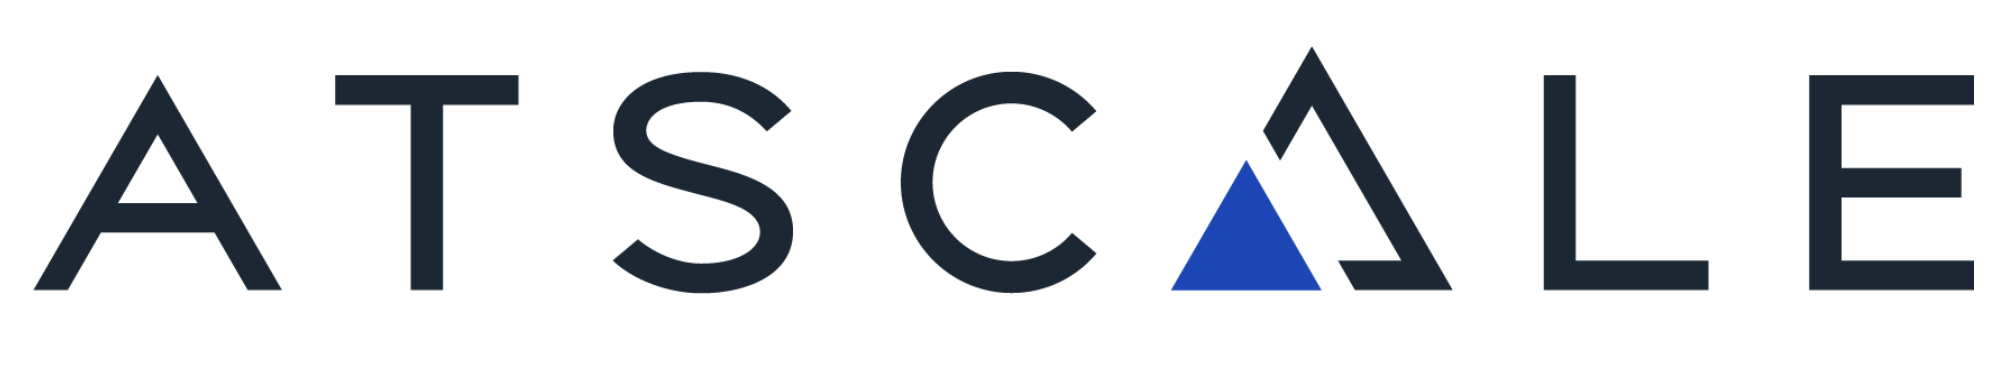